# Decision Trees and Random Forests: Application on feature data for A549 cell line in GREG.

### Author: Shaurya Jauhari (Mora Lab)
### Contact: Antonio Mora (antoniocmora@gzhmu.edu.cn)
### Last Reviewed : Dec. 14th, 2020

## Background

This notebook assesses variegated implementations of the random forest models for the data derived from the A549 cell-line in GREG. The data for this and other cell-types for GREG is available at this <a href = "https://zenodo.org/record/6339915"> link</a>. The current notebook uses the file "A549forML.txt".

## Contents

* [1. Decision Trees](#link1)
    * [1.1 Package Installation and Loading Libraries](#link2)
    * [1.2 Dataset Handling](#link3)
    * [1.3 Deploying Tree Models](#link4)
        * [1.3.1 'party' Package](#link5)
            * [1.3.1.1 SMOTE Transformation](#link6)
        * [1.3.2 'rpart' Package](#link7)
* [2. Random Forests](#link8)
    * [2.1  Core (randomForest)](#link9)
* [3. Visualizing Predictions](#link10)
* [4. Session Information](#link11)

##  <a id=link1>1. Decision Trees </a>

### <a id=link2>1.1 Package Installation and Loading Libraries </a>

In [1]:
requiredPackages <- c("party", "rpart", "rpart.plot", "ROSE", "DMwR", "randomForest")
newPackages <- requiredPackages[!(requiredPackages %in% installed.packages()[,"Package"])]
if(length(newPackages)) install.packages(newPackages,
                                         repos = "https://mirrors.tuna.tsinghua.edu.cn/CRAN/",
                                         dependencies = TRUE)

suppressPackageStartupMessages(library(party))
suppressPackageStartupMessages(library(rpart))
suppressPackageStartupMessages(library(rpart.plot))
suppressPackageStartupMessages(library(DMwR))
suppressPackageStartupMessages(library(randomForest))
suppressPackageStartupMessages(library(ROSE))
suppressPackageStartupMessages(library(ggplot2))

### <a id=link3>1.2 Dataset Handling </a>

In [2]:
a549gregStandard <- read.table("A549forML.txt", header = TRUE) ## loading full data
a549greg <- a549gregStandard[, -c(1:3)] ## removing the first three columns for non-usage in the ML model.

In [3]:
head(a549greg)

,CTCF,EP300,H3K27me3,H3K36me3,H3K4me1,H3K4me2,H3K4me3,H3K9ac,H3K9me3,RAD21,RNAPol2,YY1,Class
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1,0,0,0.00000000,0.00000000,0.00000,0,0.00000000,0.000000,0.00000000,0.0000000,0.00000000,0.00000000,Non-Hub
2,0,0,0.00000000,0.00000000,0.00000,0,0.00000000,0.000000,0.00000000,0.0000000,0.00000000,0.00000000,Non-Hub
3,0,0,0.00000000,0.00000000,0.00000,0,0.00000000,0.000000,0.00000000,0.0000000,0.00000000,0.00000000,Non-Hub
4,0,0,0.00000000,0.00000000,0.00000,0,0.00000000,0.000000,0.00000000,0.0000000,0.00000000,0.00000000,Non-Hub
5,0,0,0.00000000,0.00000000,0.00000,0,0.00000000,0.000000,0.00000000,0.0000000,0.00000000,0.00000000,Non-Hub
6,0,0,0.02727825,0.02613314,1.58534,0,0.03331304,1.537907,0.02891425,0.1631014,0.06050439,0.05796767,Non-Hub


In [4]:
rownames(a549greg) <- c()
a549greg$Class <- as.numeric(as.factor(a549greg$Class))
a549greg$Class <- ifelse(a549greg$Class == 2, 0, 1)
head(a549greg$Class)

[1] 0 0 0 0 0 0

### <a id=link4>1.3 Deploying Tree Models </a>

#### <a id=link5>1.3.1 'party' Package </a>

Let us now partition the data into training and testing subsets, as per the Pareto's dogma, i.e. maintaining 80:20 ratio for train and testing cases.

In [5]:
set.seed(3)
dataPartition <- sample(2, nrow(a549greg), replace = TRUE, prob = c(0.8,0.2))
train <- a549greg[dataPartition==1,]
test <- a549greg[dataPartition==2,]

In [6]:
cat("We have",nrow(train),"training examples and",nrow(test),"for testing.")

We have 1237967 training examples and 310325 for testing.

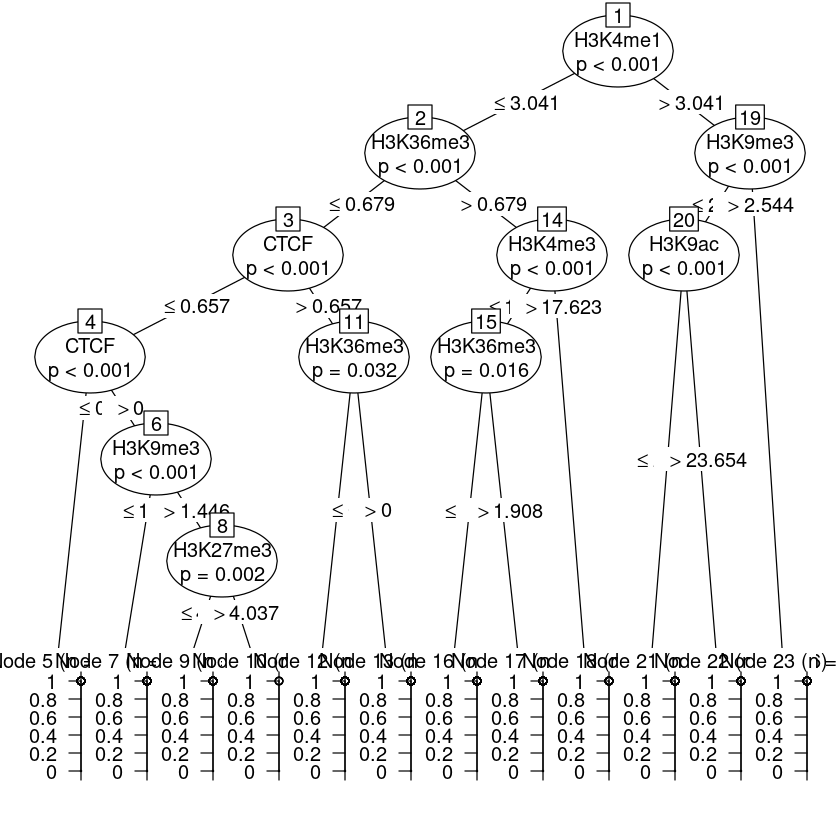

In [7]:
a549Tree <- ctree(Class ~ ., data= train)
plot(a549Tree)

The summary says that the tree has 23 overall nodes.

In [8]:
source("../../transcriptionFactoriesGREG/MachineLearning/R/modelPerformance.R")
modelPerformance(a549Tree, "rf", test, Class)

Loading required package: ggplot2


Attaching package: ‘ggplot2’


The following object is masked from ‘package:randomForest’:

    margin




The confusion matrix is
         Actual
Predicted      0      1
        0 309946    379
The accuracy of the model is 99.87787 % 
The misclassification error of the model is 0.12213 % 


[1] "Only a single class predicted. Probably skewed data handling."

In [10]:
treePred <- predict(a549Tree, test)
head(ifelse(treePred > 0.5, "Hub", "Non-Hub"))
treePred <- ifelse(treePred > 0.5, "1", "0")

Class
Non-Hub
Non-Hub
Non-Hub
Non-Hub
Non-Hub
Non-Hub


In [11]:
treePredProb <- predict(a549Tree,test, type="prob")
head(treePredProb)

[[1]]
[1] 0.0002361205

[[2]]
[1] 0.007182576

[[3]]
[1] 0.0002361205

[[4]]
[1] 0.0002361205

[[5]]
[1] 0.0002361205

[[6]]
[1] 0.0002361205

It can be articulated that the high skewness in data towards "Non-Hubs" outnumbering "Hubs" has engenedered a high-probability of classification for the former and "Hubs" haven't been predicted at all. 

Let us examine if the bifurcation of data into 7:3 ratio of training and testing sets makes any difference in the structure of the classification tree here.

In [12]:
set.seed(03)
dataPartition73 <- sample(2, nrow(a549greg), replace = TRUE, prob = c(0.7,0.3))
train73 <- a549greg[dataPartition73==1,]
test73 <- a549greg[dataPartition73==2,]

In [13]:
cat("We have",nrow(train73),"training examples and",nrow(test73),"for testing.")

We have 1083457 training examples and 464835 for testing.

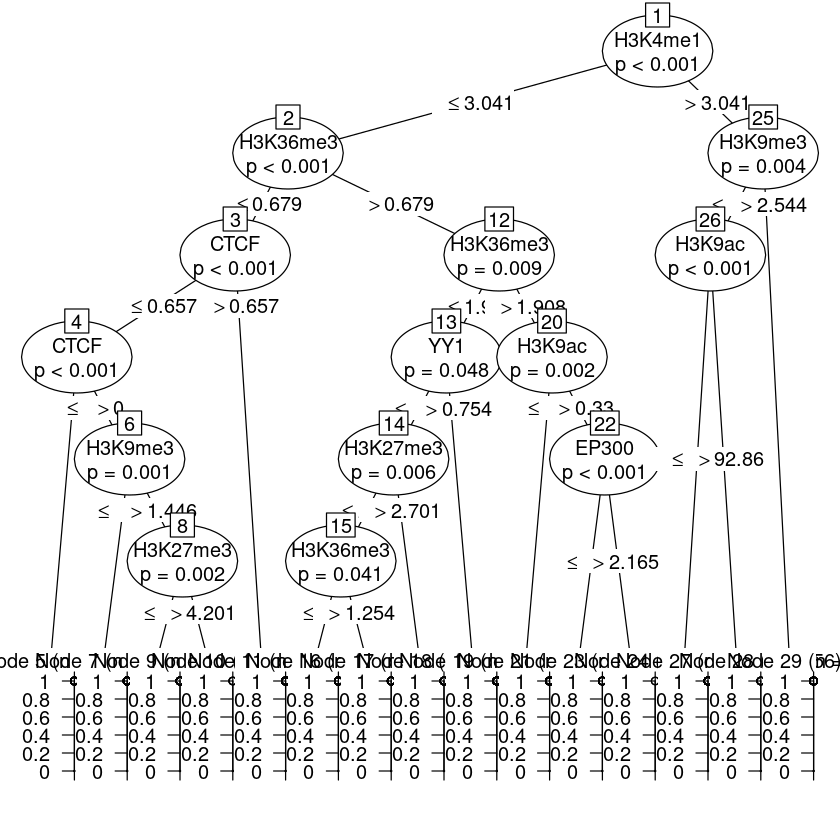

In [14]:
a549Tree73 <- ctree(Class ~ ., data= train73)
plot(a549Tree73)

In [15]:
treePred73 <- predict(a549Tree73, test73, type="response")
treePred73 <- ifelse(treePred73 > 0.5, "1", "0")

In [16]:
modelPerformance(a549Tree73, "rf", test73, Class)

The confusion matrix is
         Actual
Predicted      0      1
        0 464253    582
The accuracy of the model is 99.87479 % 
The misclassification error of the model is 0.1252057 % 


[1] "Only a single class predicted. Probably skewed data handling."

No luck here too. The data is highly biased, even for the modified data split. Let's resort to SMOTE transformation.

##### <a id=link6>1.3.1.1 SMOTE Transformation </a>

SMOTE transformation of the data has engendered fair model performance, in the case of logistic regression. See the pipeline [here](https://nbviewer.jupyter.org/github/shauryajauhari/transcriptionFactoriesGREG/blob/master/MachineLearning/LogisticRegressionA549GREG.ipynb).

In [17]:
train$Class <- as.factor(train$Class)
set.seed(77)
smoteData <- SMOTE(Class ~., train, perc.over = 10000, k = 5, perc.under = 101)
table(smoteData$Class)


     0      1 
158469 158469 

Now that the data is "perfectly" balanced, let's examine the performance of the model.

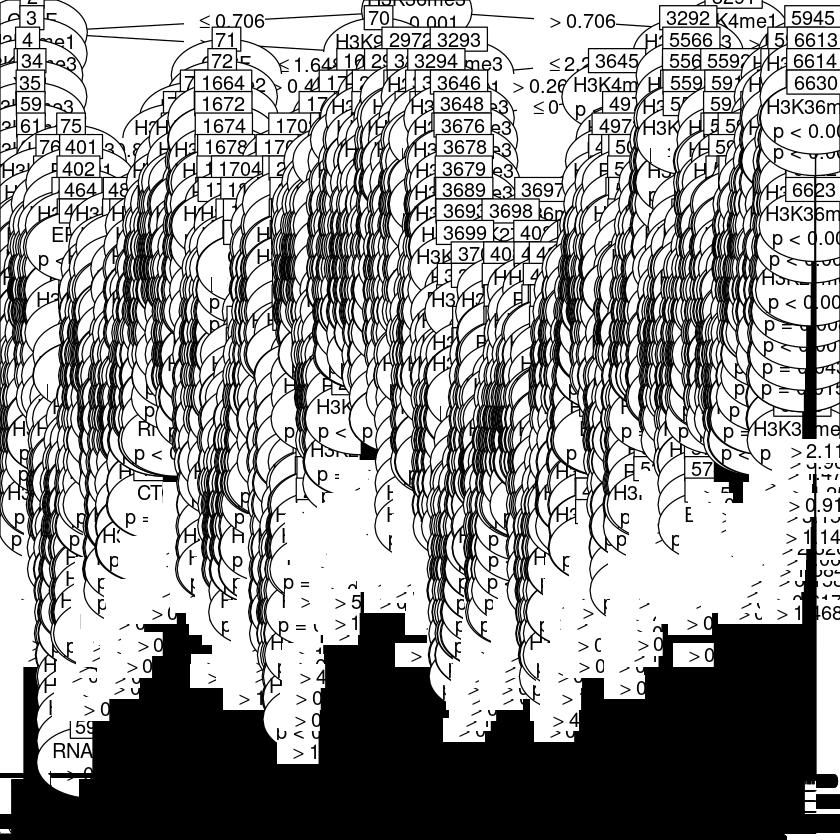

In [19]:
a549SmoteTree <- ctree(Class ~ ., data= smoteData)
plot(a549SmoteTree)

Apparently, the stablization of the class distribution in the data has made the tree more comprehensive. 

Obviously, it is hard to interpret the graphic above.

In [20]:
treeSmotePred <- predict(a549SmoteTree, test)
head(treeSmotePred)

[1] 0 0 0 0 0 0
Levels: 0 1

The confusion matrix is
         Actual
Predicted      0      1
        0 254696    206
        1  55250    173
The accuracy of the model is 82.1297 % 
The misclassification error of the model is 17.8703 % 
The sensitivity of the model is 82.17431 % 
The specificity of the model is 45.64644 % 
The area under curve is 0.6391038 



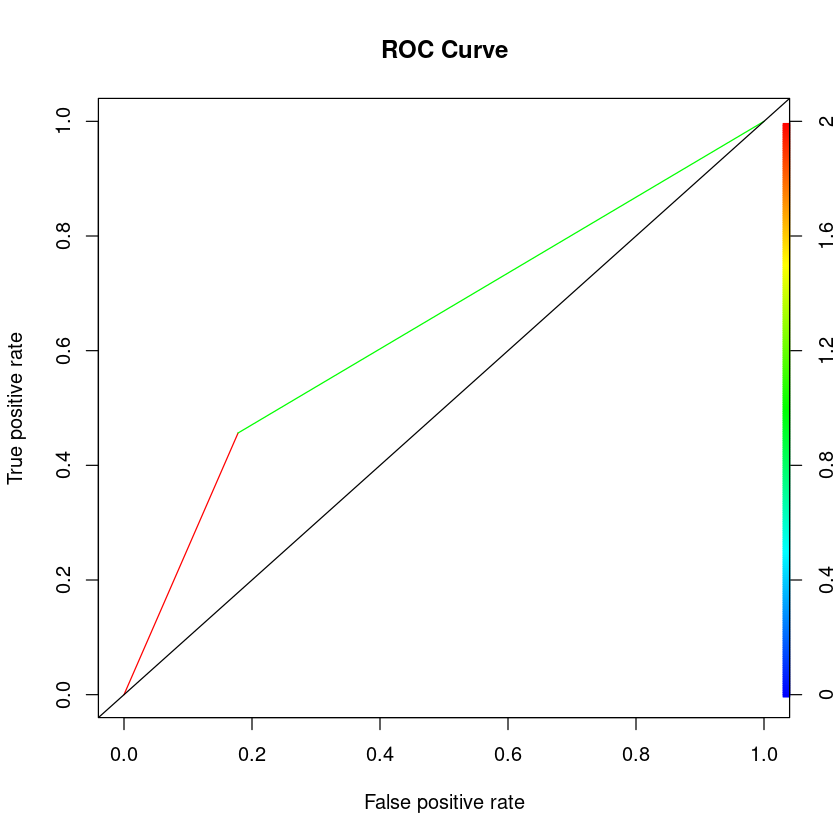

In [21]:
modelPerformance(a549SmoteTree, "rf", test, Class)

We can see distinct class indulgences, as opposed to the above cases of just "Non-Hub" instances.

The AUC and accuracy are pretty darn fair. Maybe, we should explore other options.

<p align="justify"> Addtionally, the function ctree() offers flexibility in terms of defining parameters for classification via ctree_control() function. Look for attributes *mincriterion* and *minsplit*. The former denotes the confidence level (i.e. 1- probability value), while the latter signifies the minimum number of samples required for splitting a tree branch into two. The default values are 0.95 and 20 respectively. Let us examine if any alteration makes a difference.They can be accessed via *controls*, i.e. **ctree(formula, data, controls = ctree_control(mincriterion= , minsplit= )**. </p>


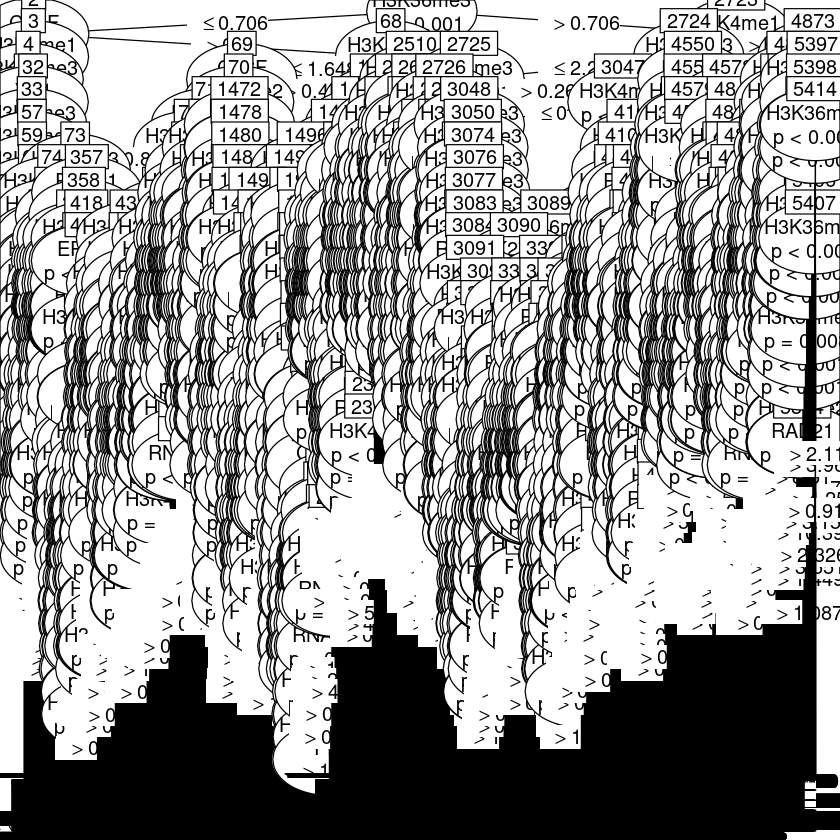

In [22]:
a549SmoteTreeAlt <- ctree(Class ~ ., data= smoteData, controls=ctree_control(mincriterion = .99, minsplit= 10))
plot(a549SmoteTreeAlt)

This tree has relatively lesser number of nodes as more stringent criteria have been imposed. Let us work out the performance metrics for this classification model for the test data.

The confusion matrix is
         Actual
Predicted      0      1
        0 251316    204
        1  58630    175
The accuracy of the model is 81.04117 % 
The misclassification error of the model is 18.95883 % 
The sensitivity of the model is 81.0838 % 
The specificity of the model is 46.17414 % 
The area under curve is 0.6362897 



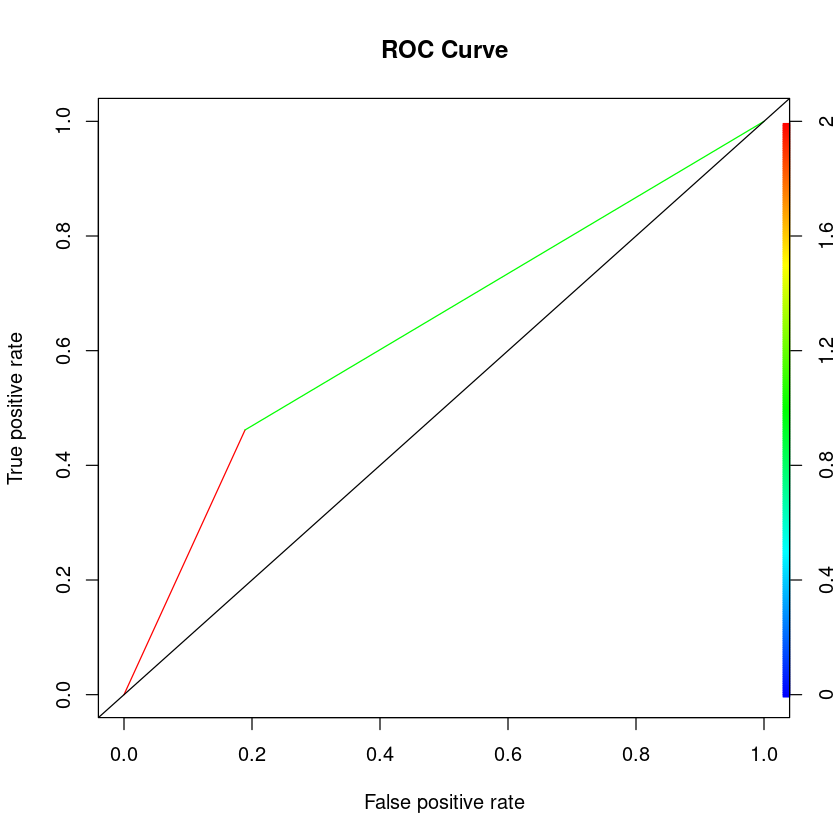

In [23]:
modelPerformance(a549SmoteTreeAlt, "RF", test, Class )

We are assuming "Hub" as a demarcation for the positive class, and so sensitivity of the model being still lower than the specificity establishes that the model is more comprehensible for the "Non-Hub" (negative class). This can again be attributed to the share of data for the respective classes. Ideally, both values be as high in magnitude, is reminiscent of a good model.  

Roughly the same proportion of sensitivity and specificity here too.

#### <a id=link7>1.3.2 'rpart' Package </a>

Using another package, we shall continue to work on the SMOTE transformed training data to model the classifier.

In [24]:
a549TreeAlt <- rpart(Class ~ ., data = smoteData)

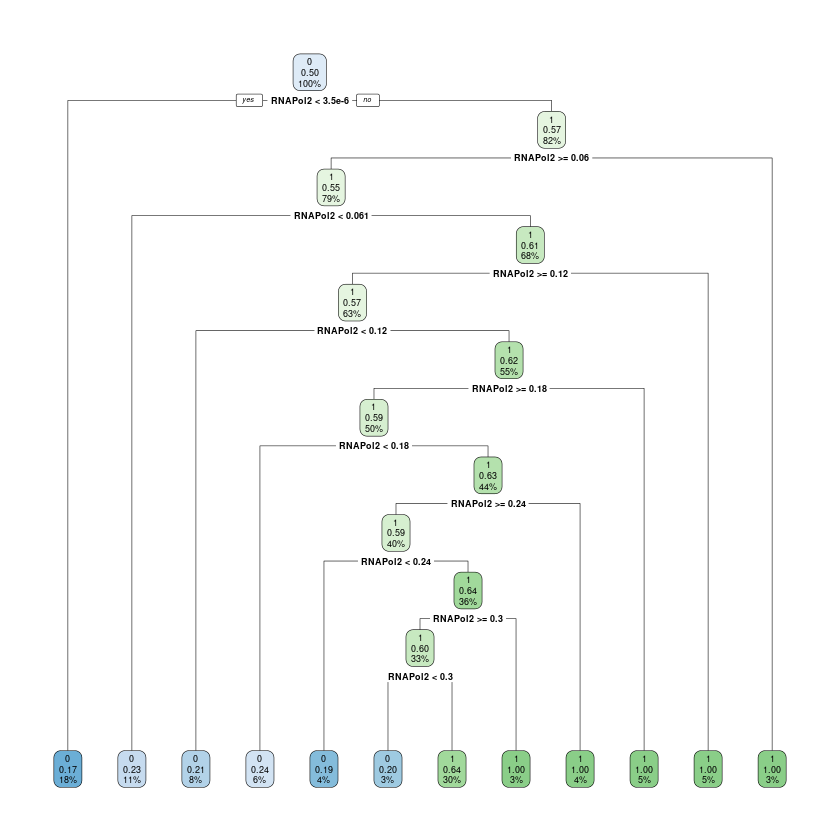

In [25]:
rpart.plot(a549TreeAlt)

We can see that the tree is hinged over the **RNAPol2** variable which innately signifies [it's] importance; also from the prespective of the **Transcription Factories**.

<p align= "justify"> There is a complete contrast between the two trees drawn from *ctree()* and *rpart()* functions. The *ctree* uses a significance test procedure in order to select variables instead of selecting the variable that maximizes an information measure (e.g. Gini coefficient). Basically the methodology of both approaches is different; *rpart* is a CART algorithm, while *party* is a CHAID algorithm (<a href="http://www.bzst.com/2006/10/classification-trees-cart-vs-chaid.html">http://www.bzst.com/2006/10/classification-trees-cart-vs-chaid.html</a>). </p>

Next, we move to the more fuller concept, of Random Forests.

##  <a id=link8>2. Random Forests </a>

<p align="justify"> Decision trees are accomodated inside Random Forests. This ensemble brings about variety in data classification and hence more robustness. This notion also helps in avoidance of overfitting. Random forests can deal with large number of features and selects them for constructing trees on the basis of importance. As we will see, they are easy to implement and have two free parameters to tune- (i) *ntree* signifying the number of trees (where default value is 500), and (ii) *mtry* denoting variables randomly selected for each split (default here sq(p) when classification is sought, and (p/3) when regression; p is the total number of features in the dataset). </p>

###  <a id=link9>2.1 Core (randomForest) </a>

There are basically three steps involved in construction of a Random Forest:
    1. Draw *ntree* bootstrap samples.
    2. For each bootstrap sample, grow a un-pruned tree by choosing best split based on a random sample of *mtry* predictors at each node.
    3. Predict new data using majority votes for classification, and average for regression based on *ntree* trees.

For application, we shall consider a subset of the data we used for decision trees. The random forests algorithm tend to consume greater in terms of computational resources.

Moving away from the Pareto's principle, let us work with 70:30 split for training and testing data.

In [26]:
## Let us work with a fraction (10%) of data. The algorithm, given the computational resources, fails in execution for the whole data. 

set.seed(8)
a549gregSample <- a549greg[sample(nrow(a549greg), replace=T, size=0.1*nrow(a549greg)),]

## Making thr response variable a 'factor', since we are attempting classification.

a549gregSample$Class <- as.factor(a549gregSample$Class)

## failing to which a warning is thrown : Warning message in randomForest.default(m, y, ...):
## “The response has five or fewer unique values.  Are you sure you want to do regression?”

dataPartition73 <- sample(2, nrow(a549gregSample), replace = TRUE, prob = c(0.7,0.3))

train73 <- a549gregSample[dataPartition73 == 1,]
test73 <- a549gregSample[dataPartition73 == 2,]

Again, the data being biased towards the negative classes, that far outnumber the instances with positive class, we shall transform the data towards being relatively heterogeneous.

In [28]:
bothTrain <- ovun.sample(Class ~., data = train73, method = "both", p =0.5, seed = 11)$data
table(bothTrain$Class)


    0     1 
53904 54285 

We have regulated the data points on near equal distribution of classes. Let us train the classifier on this data.

In [29]:
# Execute random forest algorithm

a549rf <- randomForest(formula = Class ~ ., 
                    data = bothTrain,
                   proximity = FALSE,
                   ntree = 500)
print(a549rf)


Call:
 randomForest(formula = Class ~ ., data = bothTrain, proximity = FALSE,      ntree = 500) 
               Type of random forest: classification
                     Number of trees: 500
No. of variables tried at each split: 3

        OOB estimate of  error rate: 2.84%
Confusion matrix:
      0     1 class.error
0 51830  2074  0.03847581
1  1003 53282  0.01847656


In [38]:
# Prediction and Confusion Matrix

a549PredRF <- predict(a549rf,test73)
confusionMatrix(a549PredRF, test73$Class, positive= "1")

Confusion Matrix and Statistics

          Reference
Prediction     0     1
         0 44810    44
         1  1775    11
                                          
               Accuracy : 0.961           
                 95% CI : (0.9592, 0.9627)
    No Information Rate : 0.9988          
    P-Value [Acc > NIR] : 1               
                                          
                  Kappa : 0.0097          
                                          
 Mcnemar's Test P-Value : <2e-16          
                                          
            Sensitivity : 0.2000000       
            Specificity : 0.9618976       
         Pos Pred Value : 0.0061590       
         Neg Pred Value : 0.9990190       
             Prevalence : 0.0011792       
         Detection Rate : 0.0002358       
   Detection Prevalence : 0.0382933       
      Balanced Accuracy : 0.5809488       
                                          
       'Positive' Class : 1               
                  

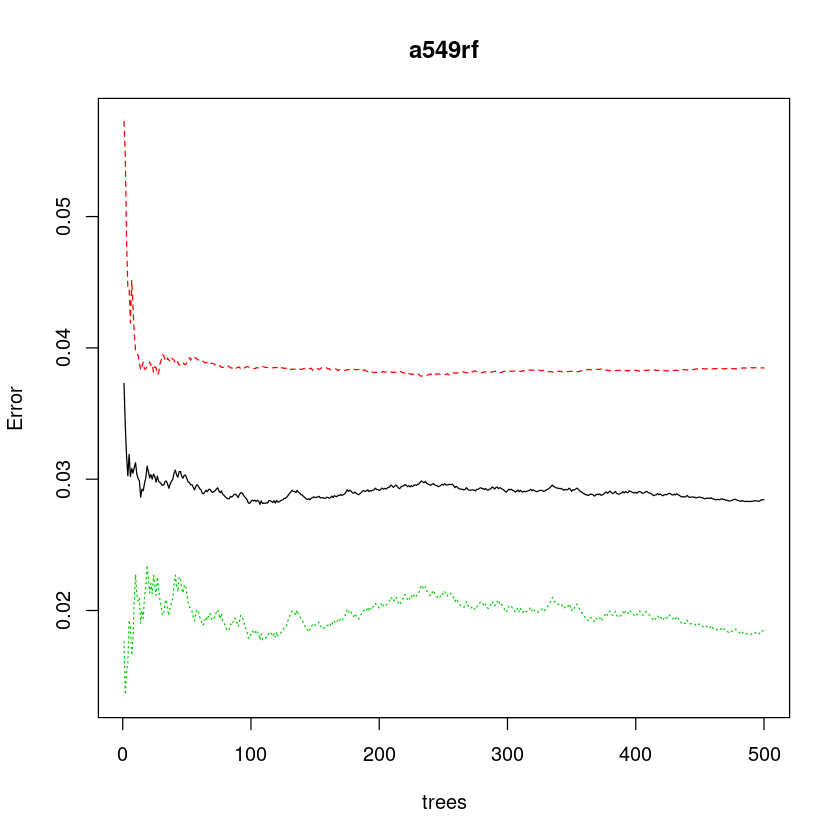

In [31]:
# Error rates (MSEs) of the Random Forest

plot(a549rf)

The above plot shows that the error rate stablises after ~400 trees and any number of trees beyond doesn't bring any betterment to the error. In view of the same, we shall tune the paramaters of our forest to reduce the number of trees from 500 (default) to 400. Let us observe the change in results. This step helps ascertain an optimal value for *ntree*. 

In [32]:
head(bothTrain)

,CTCF,EP300,H3K27me3,H3K36me3,H3K4me1,H3K4me2,H3K4me3,H3K9ac,H3K9me3,RAD21,RNAPol2,YY1,Class
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1,0.21913888,0.4010174,0.2182260,0.3919972,0.0000000,0.2272079,0.26650435,0.0000000,0.0000000,0.46212059,0.06050439,0.43475756,0
2,0.56976109,0.4010174,2.1822600,0.4181303,1.4034156,0.3786798,0.19987826,0.7323366,1.0987416,0.54367128,0.12100879,0.43475756,0
3,0.43827776,0.3208139,0.5182867,0.6794617,0.7017078,0.1514719,0.49969565,0.0000000,1.9083407,0.16310138,0.06050439,0.34780605,0
4,0.61358886,1.1763178,0.4910085,1.0975920,2.4689718,0.3786798,0.39975652,0.0000000,2.4577115,1.27762751,0.06050439,1.01443430,0
5,0.61358886,0.6683624,0.1636695,0.8362606,2.2610584,0.4922837,0.53300870,1.1351218,0.7228563,0.70677266,0.24201758,0.72459593,0
6,0.04382778,0.1604070,0.1909477,0.1306657,0.0000000,0.1893399,0.09993913,0.0000000,0.0000000,0.08155069,0.00000000,0.02898384,0


mtry = 3  OOB error = 2.84% 
Searching left ...
mtry = 2 	OOB error = 3.68% 
-0.2963204 0.005 
Searching right ...
mtry = 6 	OOB error = 1.87% 
0.3396288 0.005 
mtry = 12 	OOB error = 0.99% 
0.4704142 0.005 


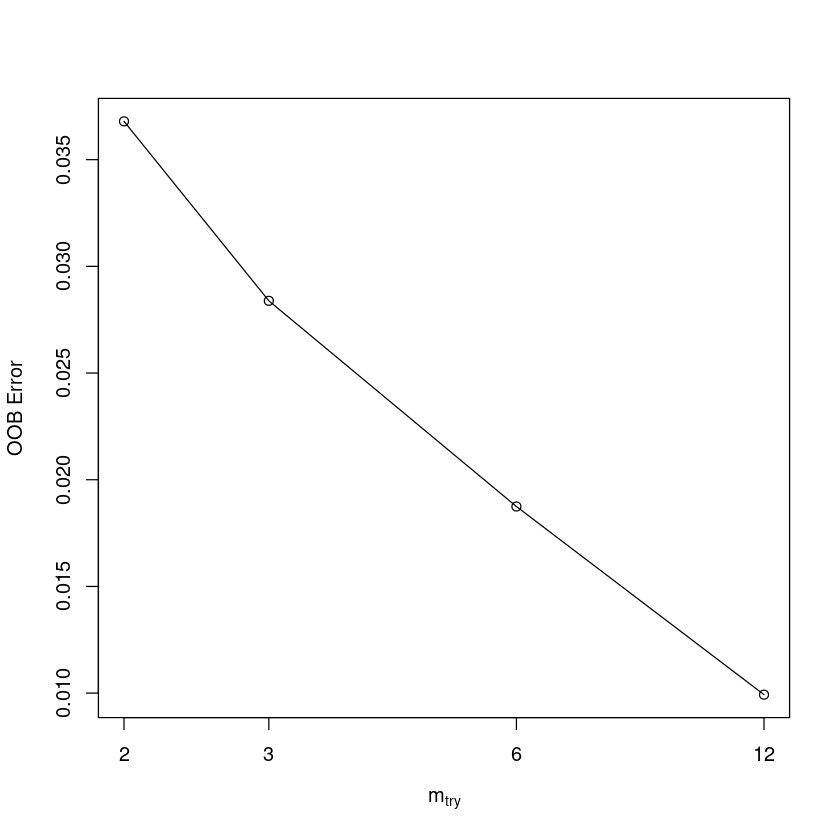

In [33]:
# Tuning mtry

t2 <- tuneRF(bothTrain[,-13], bothTrain[,13],
            stepFactor = 2,
            plot = TRUE,
            ntreeTry = 400,
            trace = TRUE,
            improve = 0.005)               

Let us increase the step factor value and try again.

mtry = 3  OOB error = 2.8% 
Searching left ...
mtry = 1 	OOB error = 5.2% 
-0.8608724 0.005 
Searching right ...
mtry = 12 	OOB error = 1% 
0.6440846 0.005 


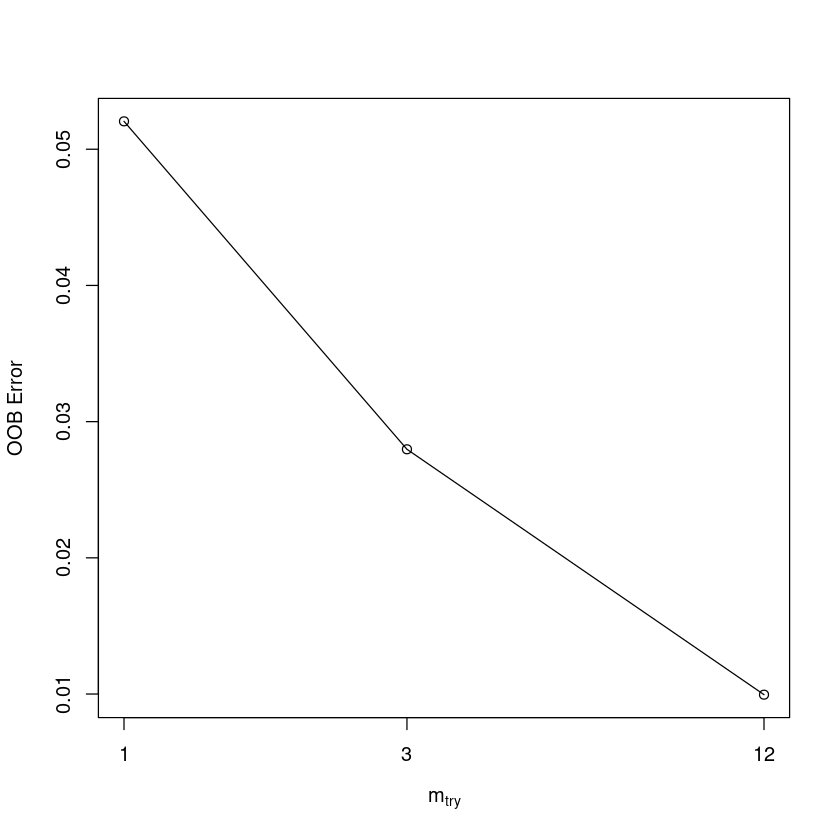

In [34]:
# Tuning with stepfactor = 5

t5 <- tuneRF(bothTrain[,-13], bothTrain[,13],
            stepFactor = 5,
            plot = TRUE,
            ntreeTry = 400,
            trace = TRUE,
            improve = 0.005)      

mtry = 3  OOB error = 2.87% 
Searching left ...
mtry = 1 	OOB error = 5.17% 
-0.8032258 0.005 
Searching right ...
mtry = 12 	OOB error = 0.99% 
0.6532258 0.005 


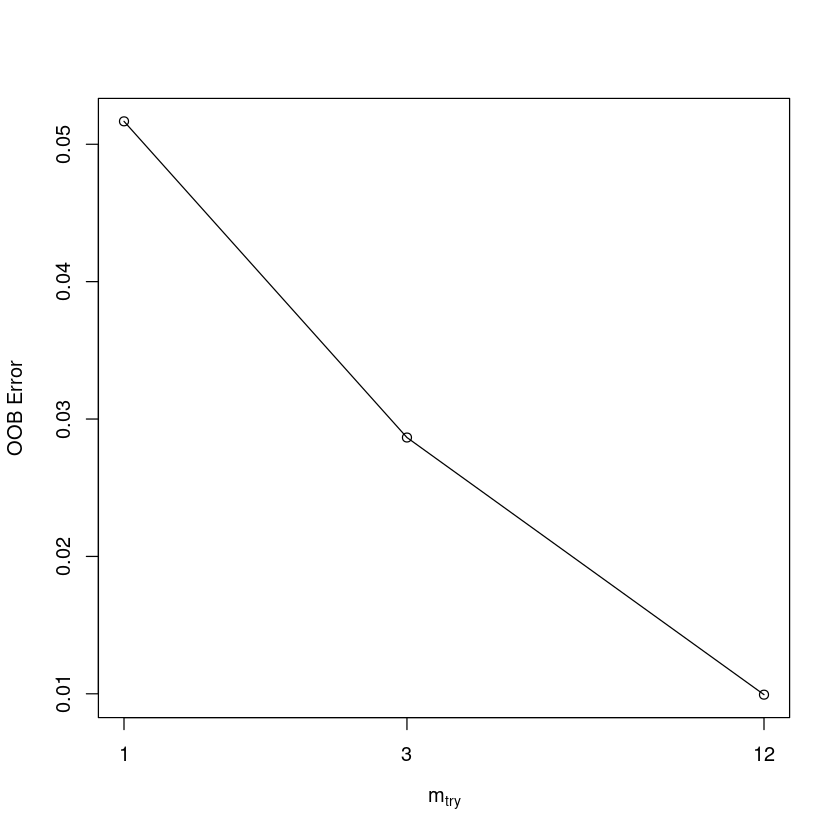

In [35]:
# Tuning with stepfactor = 4

t4 <- tuneRF(bothTrain[,-13], bothTrain[,13],
            stepFactor = 4,
            plot = TRUE,
            ntreeTry = 400,
            trace = TRUE,
            improve = 0.005)    

Thus, we see that with *stepfactor = 5, 4* no new values of mtry emerge.

We observe that OOB error stablises on assuming the random sample size of 12. This is the optimal value for *mtry* parameter. With the modified values of *mtry* and *ntree*, let us attempt our new Random Forest model. It will hopefully be an improved one.

In [36]:
a549rfOpt <- randomForest(Class~.,
                    data = bothTrain,
                    ntree = 400,
                    mtry = 12,
                    importance = TRUE,
                    proximity = FALSE)
print(a549rfOpt)     


Call:
 randomForest(formula = Class ~ ., data = bothTrain, ntree = 400,      mtry = 12, importance = TRUE, proximity = FALSE) 
               Type of random forest: classification
                     Number of trees: 400
No. of variables tried at each split: 12

        OOB estimate of  error rate: 0.99%
Confusion matrix:
      0     1 class.error
0 53321   583 0.010815524
1   492 53793 0.009063277


This is way better than the previous one, with improved accuracy as depicted below.

In [39]:
a549PredRFOpt <- predict(a549rfOpt,test73)
confusionMatrix(a549PredRFOpt, test73$Class, positive= "1")

Confusion Matrix and Statistics

          Reference
Prediction     0     1
         0 46094    47
         1   491     8
                                          
               Accuracy : 0.9885          
                 95% CI : (0.9875, 0.9894)
    No Information Rate : 0.9988          
    P-Value [Acc > NIR] : 1               
                                          
                  Kappa : 0.0268          
                                          
 Mcnemar's Test P-Value : <2e-16          
                                          
            Sensitivity : 0.1454545       
            Specificity : 0.9894601       
         Pos Pred Value : 0.0160321       
         Neg Pred Value : 0.9989814       
             Prevalence : 0.0011792       
         Detection Rate : 0.0001715       
   Detection Prevalence : 0.0106990       
      Balanced Accuracy : 0.5674573       
                                          
       'Positive' Class : 1               
                  

Again, for the issues associated with the discrepancy between sensivitiy and specificity of this model, let us switch to *smoteData* and tune the model with it.

In [40]:
# Execute random forest algorithm

a549rfSmote <- randomForest(formula = Class ~ ., 
                    data = smoteData,
                   proximity = FALSE,
                   ntree = 500)
print(a549rfSmote)


Call:
 randomForest(formula = Class ~ ., data = smoteData, proximity = FALSE,      ntree = 500) 
               Type of random forest: classification
                     Number of trees: 500
No. of variables tried at each split: 3

        OOB estimate of  error rate: 3.44%
Confusion matrix:
       0      1 class.error
0 151596   6873  0.04337126
1   4030 154439  0.02543084


The confusion matrix is
         Actual
Predicted      0      1
        0 296608    249
        1  13338    130
The accuracy of the model is 95.62169 % 
The misclassification error of the model is 4.378313 % 
The sensitivity of the model is 95.69667 % 
The specificity of the model is 34.30079 % 
The area under curve is 0.6499873 



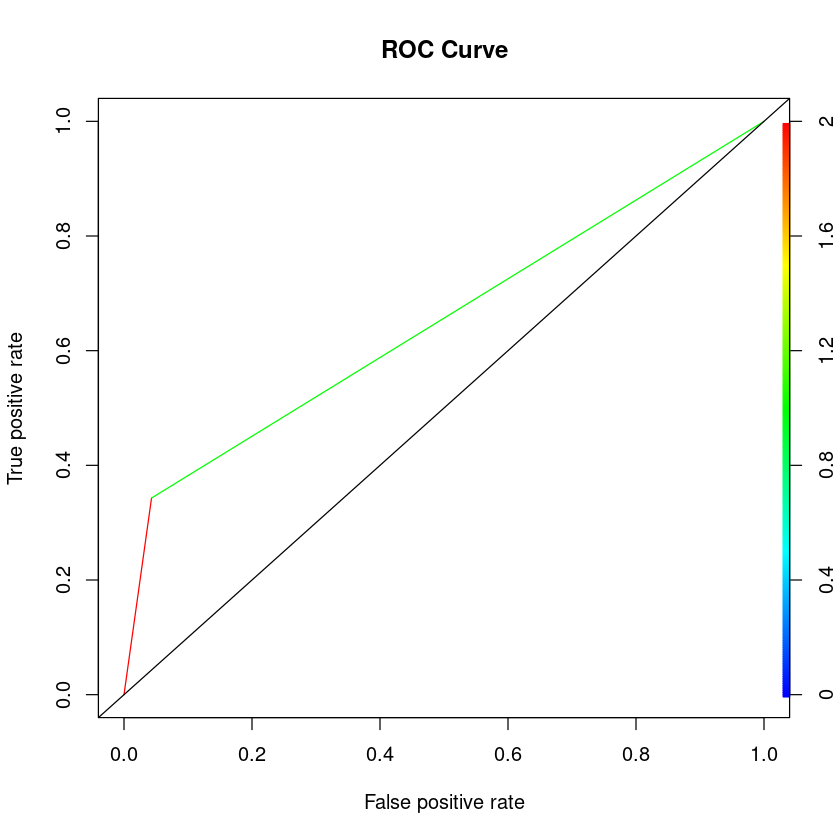

In [41]:
# Prediction and Confusion Matrix

modelPerformance(a549rfSmote, "rf", test, Class)

So the ability of the model to predict poitive class has definitely come up a bit, although it is not as par with the specificity.

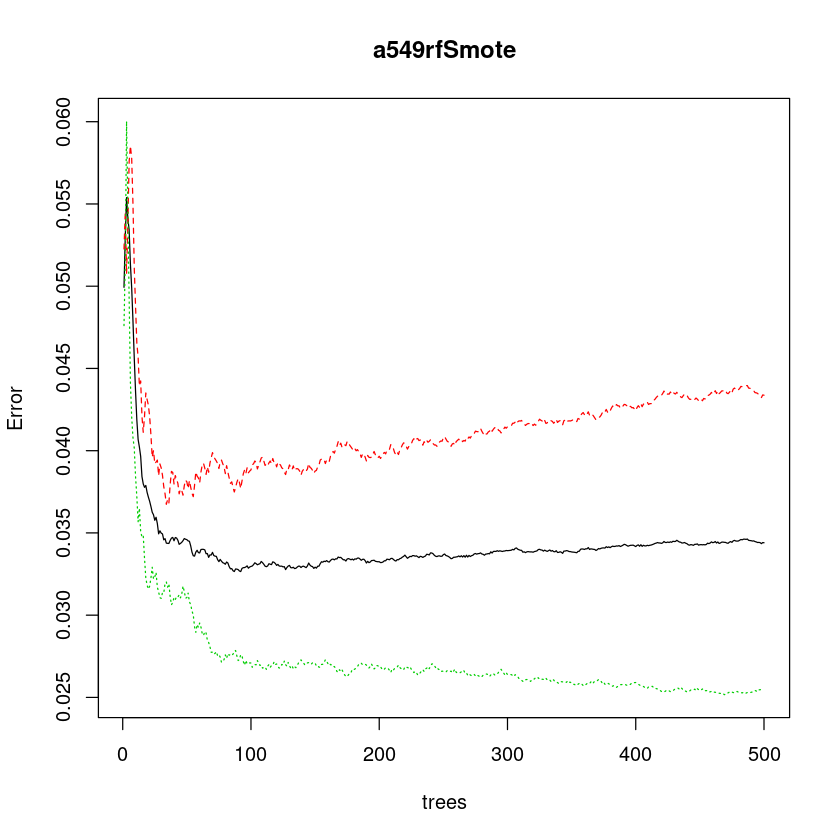

In [52]:
plot(a549rfSmote) ## error rates for the random forest model

Again, a little jittery at the beginning, but the error terms for this model also roughly iron-out after *400* trees.

In [43]:
head(smoteData)

,CTCF,EP300,H3K27me3,H3K36me3,H3K4me1,H3K4me2,H3K4me3,H3K9ac,H3K9me3,RAD21,RNAPol2,YY1,Class
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
745308,0.4382778,0.0000000,0.0000000,0.000000,0.000000,0.0000000,0.0000000,0.000000,0.000000,0.0000000,0.0000000,0.0000000,0
418949,0.6135889,1.5238662,0.7092345,1.332790,0.000000,0.5680196,0.6995739,0.000000,0.000000,1.1960768,0.2420176,2.1737878,0
255122,0.1753111,0.3208139,0.8456257,0.000000,0.000000,0.1514719,0.4663826,0.000000,0.000000,0.5164877,0.2420176,0.6086606,0
400742,0.7012444,1.1763178,0.7092345,1.228258,10.343693,4.7713649,2.7982957,6.554413,2.052912,1.3863618,0.0000000,1.2173212,0
1419651,0.6574166,1.1228488,0.3546172,2.508782,0.000000,0.5301517,0.5663217,0.000000,0.000000,0.7339562,0.4235308,0.8405313,0
1377418,1.0518666,1.0961143,0.1909477,1.672521,4.626074,0.8330955,0.5996348,2.013926,1.792684,1.1960768,0.7865571,1.0434181,0


mtry = 3  OOB error = 3.33% 
Searching left ...
mtry = 2 	OOB error = 4.2% 
-0.2627834 0.005 
Searching right ...
mtry = 6 	OOB error = 1.91% 
0.4259558 0.005 
mtry = 12 	OOB error = 1.78% 
0.06544373 0.005 


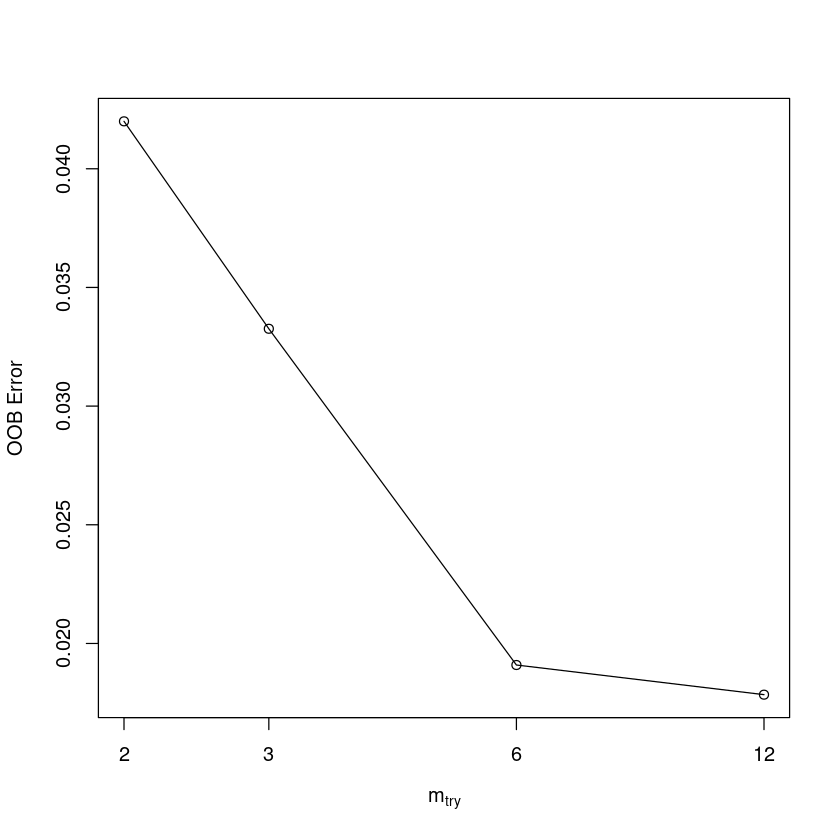

In [44]:
# Tuning mtry

t5 <- tuneRF(smoteData[,-13], smoteData[,13],
            stepFactor = 2,
            plot = TRUE,
            ntreeTry = 400,
            trace = TRUE,
            improve = 0.005)  

The error is least at the sample size of 12. This result aligns with the report from the previous model (with *bothTain* data). We'll stick with this number and proceed with the current model.

In [45]:
a549rfSmote1 <- randomForest(Class~.,
                    data = smoteData,
                    ntree = 400,
                    mtry = 12,
                    importance = TRUE,
                    proximity = FALSE)
print(a549rfSmote1)     


Call:
 randomForest(formula = Class ~ ., data = smoteData, ntree = 400,      mtry = 12, importance = TRUE, proximity = FALSE) 
               Type of random forest: classification
                     Number of trees: 400
No. of variables tried at each split: 12

        OOB estimate of  error rate: 1.79%
Confusion matrix:
       0      1 class.error
0 156506   1963  0.01238728
1   3697 154772  0.02332948


The confusion matrix is
         Actual
Predicted      0      1
        0 306188    263
        1   3758    116
The accuracy of the model is 98.70426 % 
The misclassification error of the model is 1.295738 % 
The sensitivity of the model is 98.78753 % 
The specificity of the model is 30.60686 % 
The area under curve is 0.646972 



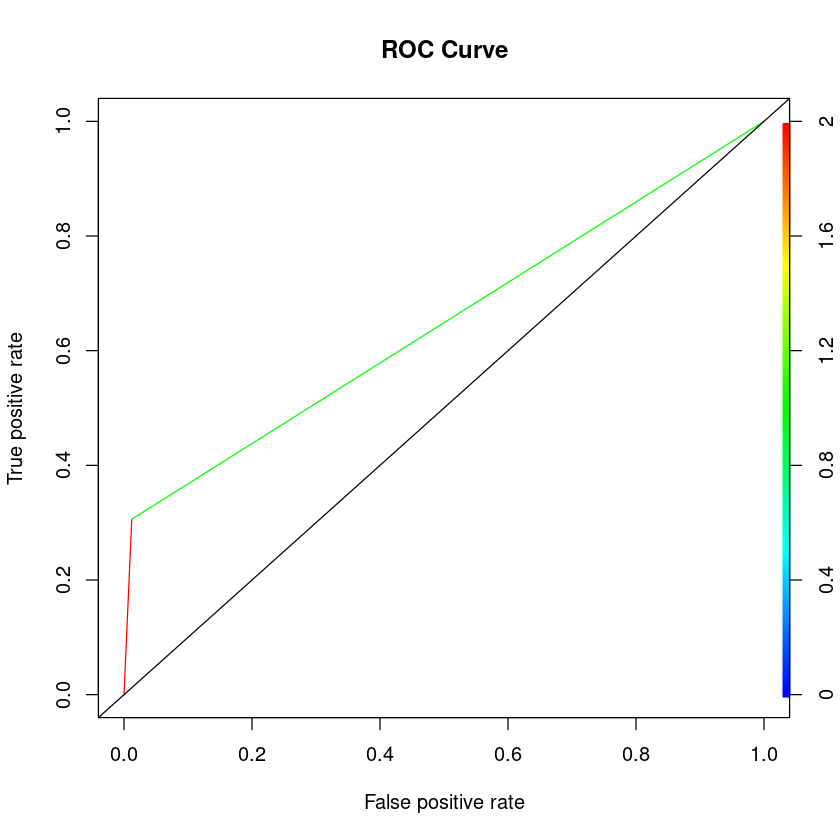

In [54]:
modelPerformance(a549rfSmote1, "rf", test, Class)

This is slighter less efficient to the previous model. Let us explore the attributes for the model *a549rfSmote*.

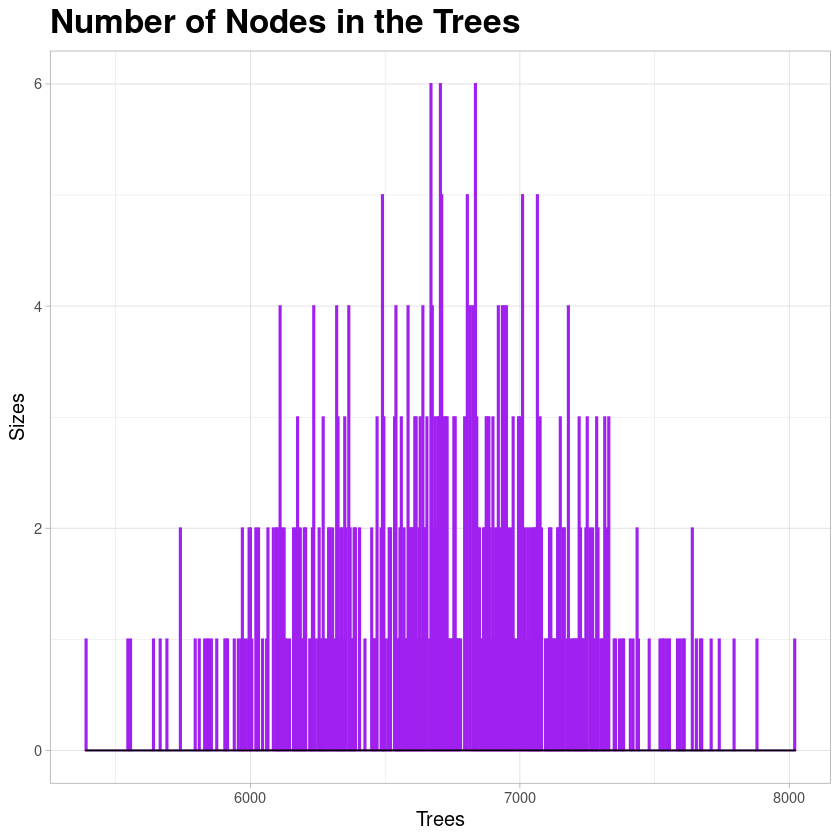

In [55]:
# Number of nodes for the trees

ts <- as.data.frame(treesize(a549rfSmote), row.names = c())
ggplot(data = ts, aes(x = `treesize(a549rfSmote)`)) + 
  geom_histogram(binwidth = 5, color="purple", fill="lavender", position="identity", alpha=0.7)+
  labs(x="Trees", y="Sizes")+
  ggtitle("Number of Nodes in the Trees")+
  geom_density(alpha=0.6)+
  theme_light()+
  theme(plot.title= element_text(size = 20, face = "bold"),
        axis.title = element_text(size = 12))

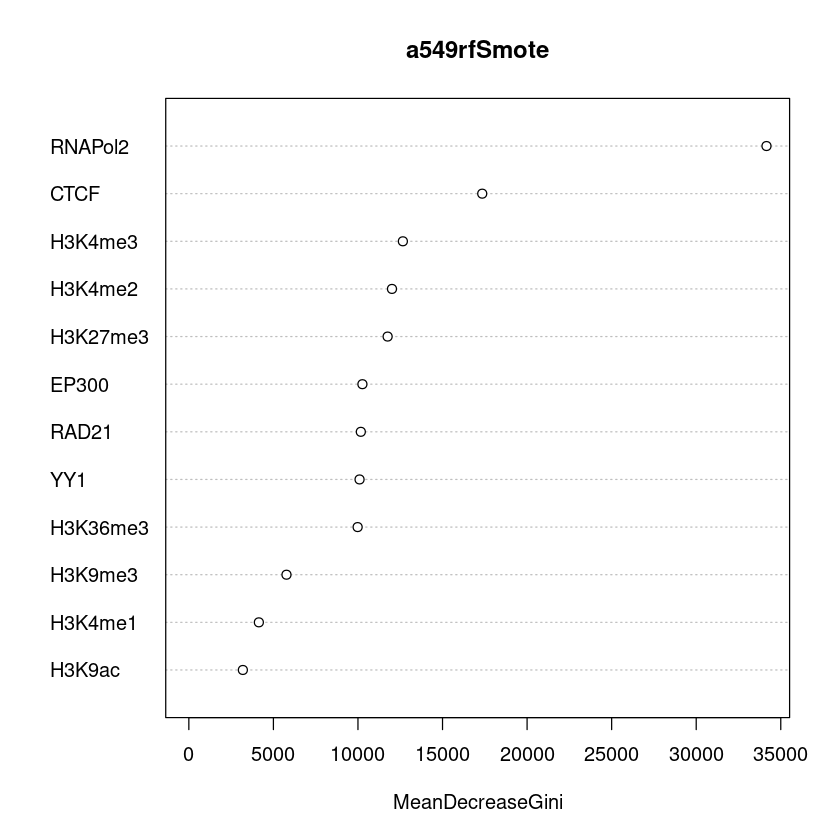

In [56]:
# Variable Importance

varImpPlot(a549rfSmote)

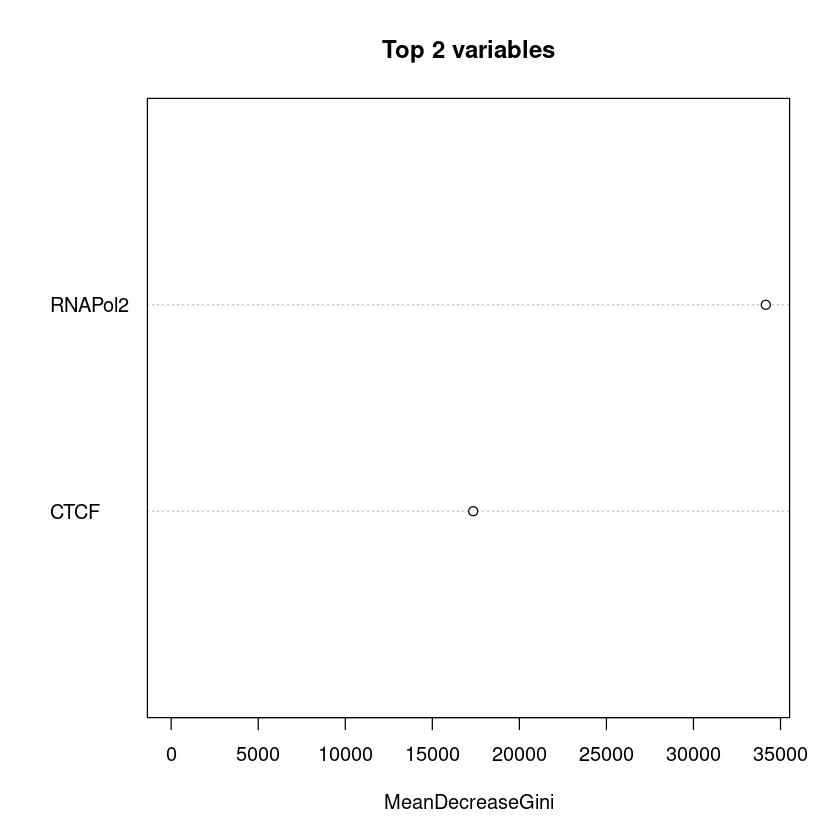

In [57]:
varImpPlot(a549rfSmote , sort = TRUE, n.var = 2, main = "Top 2 variables")

In [58]:
importance(a549rfSmote)

,MeanDecreaseGini
CTCF,17347.269
EP300,10262.981
H3K27me3,11753.578
H3K36me3,9980.323
H3K4me1,4139.853
H3K4me2,12010.938
H3K4me3,12654.851
H3K9ac,3193.937
H3K9me3,5773.487
RAD21,10168.956


In [59]:
varUsed(a549rfSmote)

[1] 335059 314768 348392 334007 142623 315806 324073 110760 203540 328861
[11] 282946 316850

This classification model of random forests projects **H3K27me3** as the most crucial variable with maximum instances used while contruction of trees. It is studied to be a key mediator in [chromatin colocalization](https://science.sciencemag.org/content/312/5771/269.full). In addition, **RNAPol2** is considered to be an important variable for the model. As we shall see below, it has a stable and a relatively high support for the model.

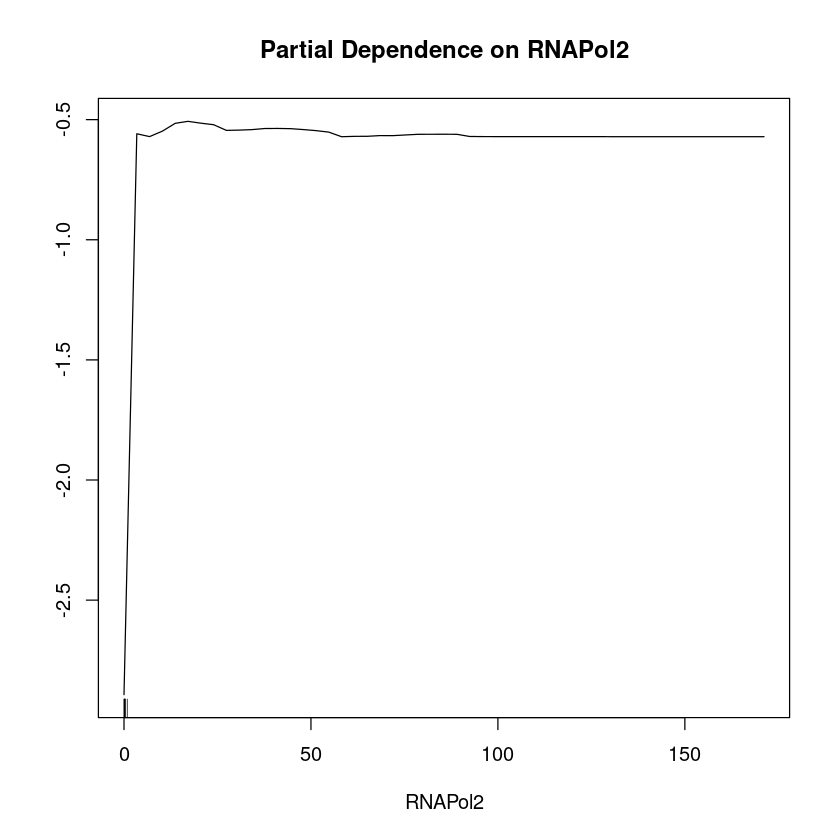

In [60]:
# Partial Dependence Plots | Class "1" is our positive class - "Hub".

partialPlot(a549rfSmote, smoteData, RNAPol2 , "1")

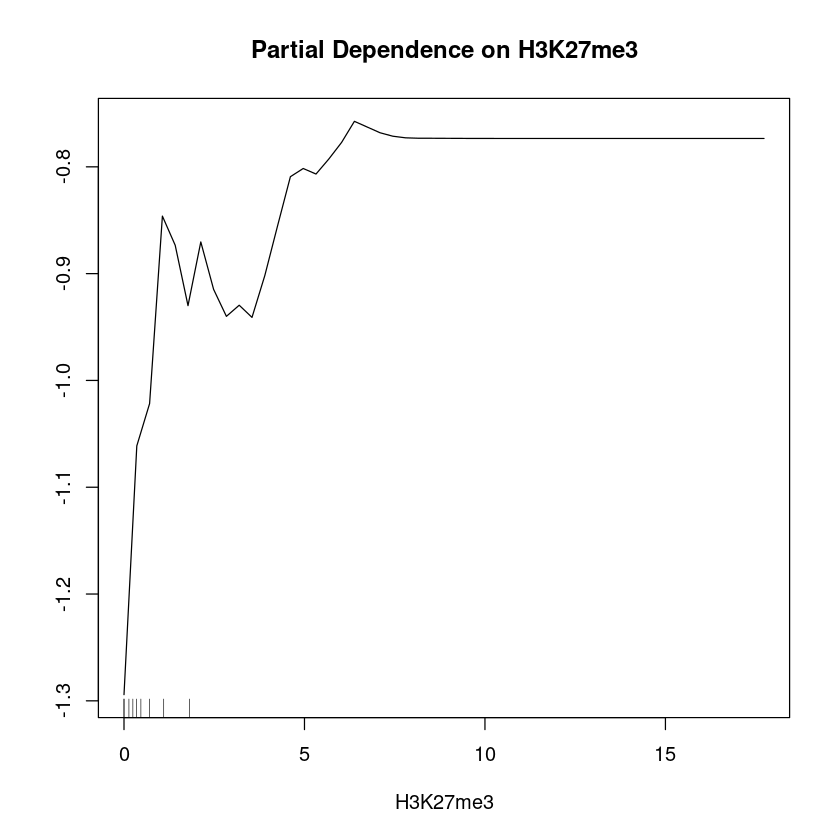

In [61]:
partialPlot(a549rfSmote, smoteData, H3K27me3, "1")

<p align="justify"> The partial dependence plot represents a variable's contribution to the probability of class depiction (classification). The variable contribution of H3K27me3 is initially a bit sluggish and imprecise, but consolidates later at a higher level. Complimenatrily, as seen below, CTCF too has determinism in the model. </p>

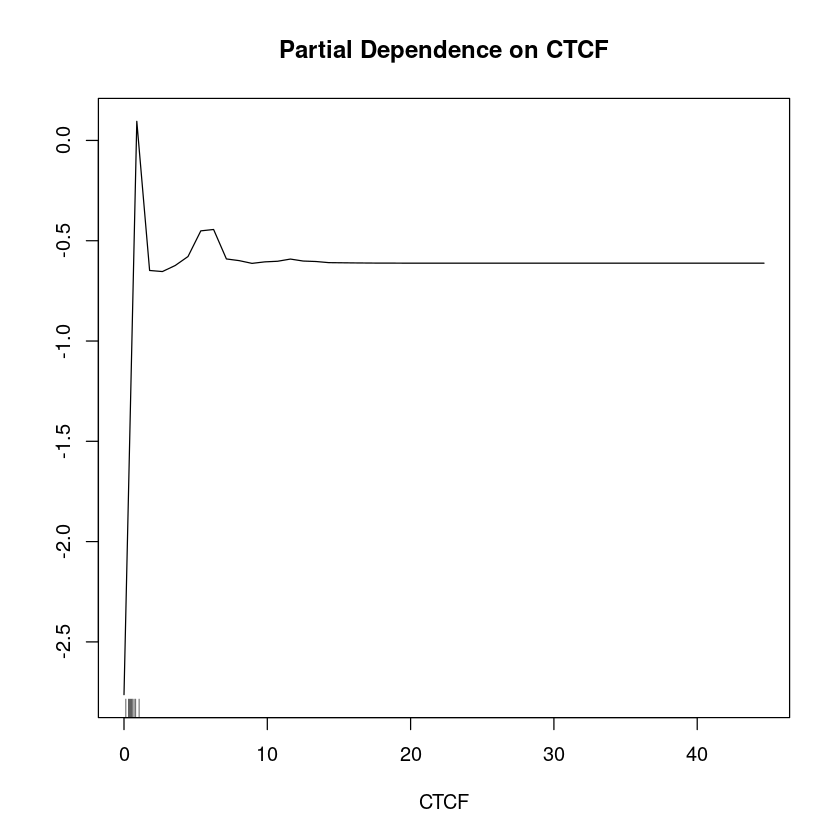

In [62]:
partialPlot(a549rfSmote, smoteData, CTCF, "1")

##  <a id=link10>3. Visualizing Predictions </a>

We choose to go with this model and will save the prediction results, that shall be later utilized for plotting.

In [64]:
a549gregModelPredictions <- predict(a549rfSmote, a549greg, type = "response")
a549gregModelPredictionsProbs <- as.factor(a549gregModelPredictions)

In [65]:
head(a549gregModelPredictionsProbs)

1 2 3 4 5 6 
0 0 0 0 0 0 
Levels: 0 1

Eventually, we have the original dataset with the classes and the one with the model predictions. We attempt to map the prediction results corresponding to LR-Hubs from the A549 cell-line. It will be interesting to see the intersect of the pre-caliberated LR-Hubs and the ones predicted by the classifier.

<a href = "http://www.bioconductor.org/packages/release/bioc/html/Gviz.html" > Gviz</a> is the package we aim to deploy for visualization.

In [66]:
if(!requireNamespace("BiocManager", quietly = TRUE))
BiocManager::install("Gviz")
suppressPackageStartupMessages(library(Gviz))

Next, we recall the data from the A549 cell-line (GREG). We already know, this is a comprehensive data (genome-wide) with values corresponding to epigenetic marks (features) for each bin (a 2Kb genomic region), in addition to a "Class", i.e. a "Hub" or a "Non-Hub". For the present case, we shall prune the data for the genomic intervals and their corresponding class. That is all we need! 

In [67]:
a549gregStandardRegionsClass <- a549gregStandard[, c(1:3,16)]

Also, considering the computational resources we deploy, we shall focus on chromosome 21 only.

In [68]:
## Extracting chr21 data

a549gregChr21NonHub <- a549gregStandardRegionsClass[a549gregStandardRegionsClass$chr=="chr21" & a549gregStandardRegionsClass$Class=="Non-Hub", ] ## subset of data for exemplifying
a549gregChr21Hub <- a549gregStandardRegionsClass[a549gregStandardRegionsClass$chr=="chr21" & a549gregStandardRegionsClass$Class=="Hub", ]

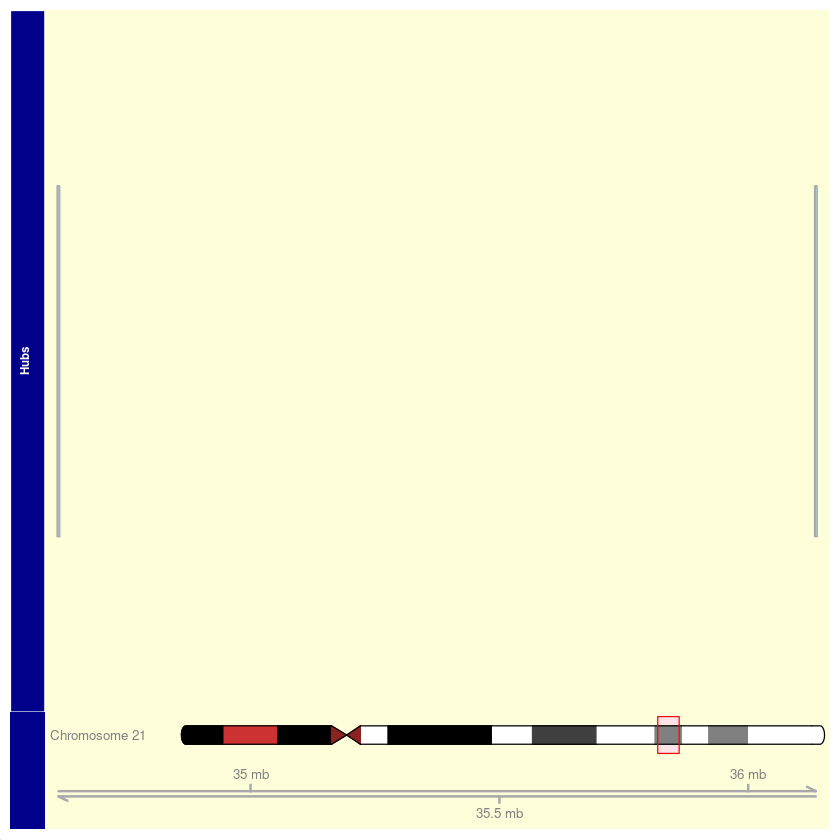

In [69]:
# Plotting Hubs

annotationTrackHub <- AnnotationTrack(range = a549gregChr21Hub, 
                                      name = "Hubs", 
                                      genome = "hg38", 
                                      chromosome = "chr21")
itrack <- IdeogramTrack(genome = "hg38", chromosome = "chr21")
genomeTrack <- GenomeAxisTrack()
plotTracks(list(annotationTrackHub, itrack, genomeTrack), 
           background.panel = "#FFFEDB", 
           background.title = "darkblue",
           stacking = "dense")

In [70]:
print(a549gregChr21Hub)

         chr    start      end Class
814391 chr21 34612001 34614000   Hub
814392 chr21 34614001 34616000   Hub
815152 chr21 36134001 36136000   Hub
815153 chr21 36136001 36138000   Hub


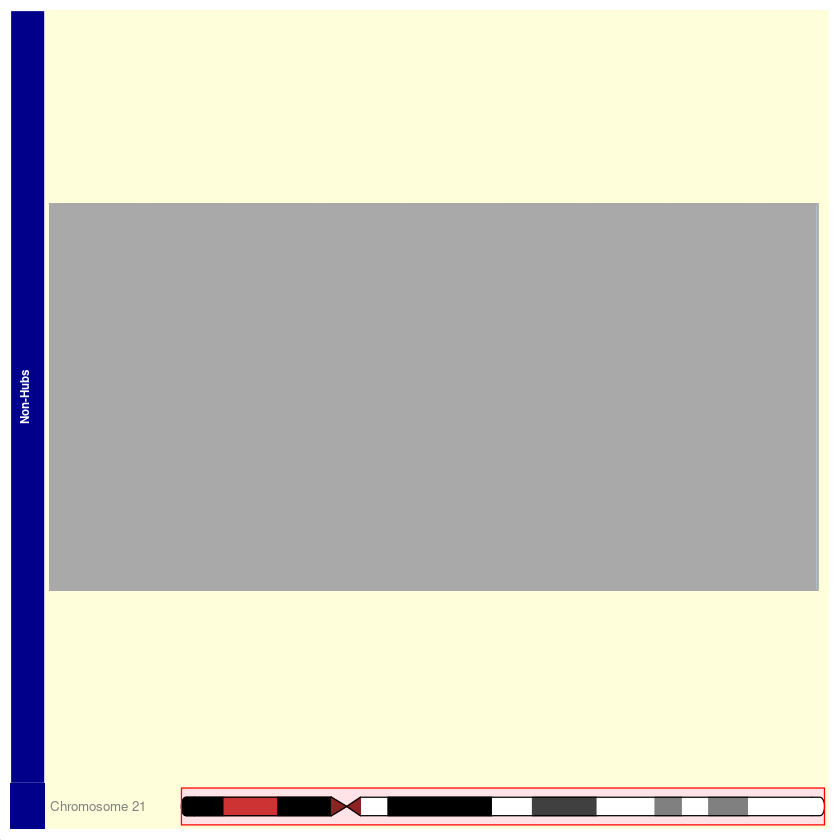

In [71]:
# Plotting Non-Hubs

annotationTrackNonHub <- AnnotationTrack(range = a549gregChr21NonHub, 
                                         name = "Non-Hubs", 
                                         genome = "hg38", 
                                         chromosome = "chr21")
itrack <- IdeogramTrack(genome = "hg38", chromosome = "chr21")
plotTracks(list(annotationTrackNonHub, itrack),
           background.panel = "#FFFEDB", 
           background.title = "darkblue",
           stacking = "dense")

We can observe that the Non-Hubs are pretty evenly distributed throughout the chromosome.In contrast, we are curious to examine if the findings of the classifier are able to fortify the original class definitions. Let us frame the data from the predicted results. 

In [72]:
a549gregPredicted <- cbind(a549gregStandardRegionsClass, a549gregModelPredictionsProbs)
names(a549gregPredicted)[names(a549gregPredicted) == "a549gregModelPredictionsProbs"] <- "Prediction"
a549gregPredicted$Prediction <- ifelse(a549gregPredicted$Prediction == 1, "Hub", "Non-Hub")  

Let us see if the classifier predictions match with the original results.

In [73]:
a549gregChr21PredicitedHub <- a549gregPredicted[a549gregPredicted$chr=="chr21" & a549gregPredicted$Prediction =="Hub", ]

Certainly, the predicted hubs are far more in number and there are noticeable instances of "Non-Hubs" that have been classified as "Hubs", with the given profile of the classification model.  

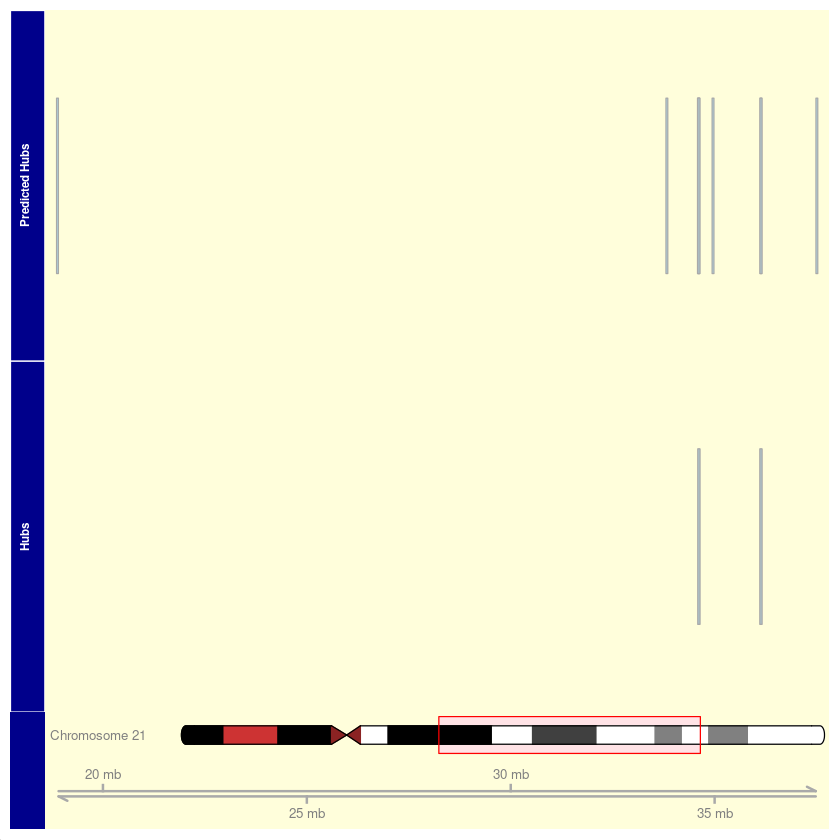

In [74]:
# Plotting Predicted Hubs
annotationTrackHub <- AnnotationTrack(range = a549gregChr21Hub, 
                                      name = "Hubs", 
                                      genome = "hg38", 
                                      chromosome = "chr21")
annotationTrackPredictedHub <- AnnotationTrack(range = a549gregChr21PredicitedHub, 
                                               name = "Predicted Hubs", 
                                               genome = "hg38", 
                                               chromosome = "chr21")
itrack <- IdeogramTrack(genome = "hg38", chromosome = "chr21")
genomeTrack <- GenomeAxisTrack()
plotTracks(list(annotationTrackPredictedHub,annotationTrackHub, itrack, genomeTrack), 
           background.panel = "#FFFEDB", 
           background.title = "darkblue",
           stacking = "dense")

In [75]:
truePositives <- a549gregPredicted[a549gregPredicted$Class == a549gregPredicted$Prediction, ]

As we close, we'll save the optimal model and true positive genomic regions (hubs) as explicit R data objects, in order to recall for later use.

In [76]:
## Saving relevant files

save(a549rfSmote, file = "./optimalModels/a549modelRF") # optimal model
write.table(truePositives, file = "./truePositives/a549RF.txt", quote = FALSE) # true positives: precicted ~ original
write.table(smoteData, file = "./buildData/optimalModelTrainA549RF.txt", quote = FALSE) # data used to train model
write.table(test, file = "./buildData/optimalModelTestA549RF.txt", quote = FALSE) # data used to test model

### Conclusion

We see that the best performing model isn't just graded by its accuracy (which is corresponding to the current state of class distribution), but by how well it is able to differentiate between the negative and positive classes. Considering the same as premise, we identified that the following is the best performing model with related attributes.

| Best Model | Accuracy | Sensitivity | Specificity | Remark
| --- | --- | --- | --- | ---
| a549rfSmote | 95.62169 % | 95.69667 % | 34.30079 % | Moderate

Also, note that data on which the model was trained has a distribution of 158469:158469 = 1 in class proportion. So, the probability of finding any class is 50% (ideally) because we have a homogeneous spread of class labels. Despite since the model has higher sensitivity, i.e. higher knack for predicting positive classes, the performance is pretty moderate despite of higher accuracy.  

##  <a id=link11>4. Session Information </a>

In [78]:
sessionInfo()

R version 3.6.0 (2019-04-26)
Platform: x86_64-redhat-linux-gnu (64-bit)
Running under: CentOS Linux 7 (Core)

Matrix products: default
BLAS/LAPACK: /usr/lib64/R/lib/libRblas.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
 [1] parallel  stats4    grid      stats     graphics  grDevices utils    
 [8] datasets  methods   base     

other attached packages:
 [1] Gviz_1.30.3          GenomicRanges_1.38.0 GenomeInfoDb_1.22.1 
 [4] IRanges_2.20.2       S4Vectors_0.24.4     BiocGenerics_0.32.0 
 [7] ROCR_1.0-11          caret_6.0-86         ggplot2_3.3.2       
[10] e1071_1.7-3          ROSE_0.0-3           randomForest_4.6-14 
[13] DMwR_0.4.1           l